In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os

import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image

In [17]:
base_dir = "/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp"

import dataloading

# rsync command:
# rsync --ignore-existing --progress -avhze ssh Franka_TeleOp gsk6me@rivanna.hpc.virginia.edu:/project/CollabRoboGroup/gsk6me/real_frankadata

df = dataloading.get_demonstrations_index(base_dir)
df

,Participant,Task,Interface,Trial
0,1,1,2,1
1,1,1,3,1
2,1,3,1,1
3,1,3,2,1
4,1,3,3,2
...,...,...,...,...
411,34,6,1,1
412,34,6,2,1
413,34,6,3,1
414,34,8,1,1


In [5]:
# Find VR examples
all_data = []
successful_rows = []
vr_df = df[df['Interface'] == 3]

for i, row in vr_df.iterrows():
    participant_id, task_id, _, trial_id = row
    
    try:
        all_data.append(get_vr_data(base_dir, participant_id, task_id, trial_id))
    except:
        print("Missing:", row)
        continue
        
    successful_rows.append(row)


Missing: Participant    2
Task           3
Interface      3
Trial          1
Name: 19, dtype: int64
Missing: Participant    13
Task            3
Interface       3
Trial           1
Name: 95, dtype: int64
Missing: Participant    13
Task            5
Interface       3
Trial           1
Name: 98, dtype: int64
Missing: Participant    22
Task            2
Interface       3
Trial           1
Name: 216, dtype: int64


In [16]:
import numpy as np



[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 56, 61, 66, 71, 76, 81, 88, 93, 98, 103, 114, 119, 124, 129, 134, 146, 151, 156, 161, 176, 181, 186, 191, 197, 202, 212, 217, 222, 227, 232, 237, 242, 247, 252, 257, 262, 267, 272, 277, 286, 291, 296, 301, 310, 315, 326, 331, 338, 343, 348, 353, 358, 363, 368, 373, 375]


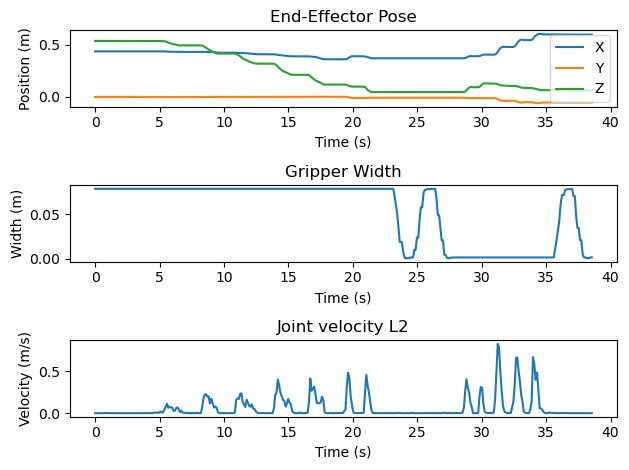

In [20]:
import matplotlib.pyplot as plt
from detect_keypoints import find_keypoints

result = dataloading.collate_observations(all_data[10])
keypoints = find_keypoints(result)
# Will need a better keypoint detection method, or some other way to encode motion plans.
print(keypoints)

dataloading.plot_demonstration(result)

In [175]:
# Group observations by Task ID
for task_id, indices in vr_df.groupby('Task').groups.items():
    print(f"Task ID {task_id}: {indices.tolist()}")
    
for i, row in enumerate(successful_rows):
    if row.name == 59:
        print(i)

Task ID 1: [1, 14, 30, 44, 59, 73, 74, 90, 104, 117, 131, 143, 157, 171, 186, 262]
Task ID 2: [216, 230, 248, 282, 296, 314, 331, 345, 362, 378, 393, 406]
Task ID 3: [4, 18, 19, 34, 49, 62, 63, 77, 94, 95, 107, 121, 134, 146, 161, 191, 192, 206]
Task ID 4: [219, 220, 233, 252, 268, 269, 270, 286, 299, 300, 301, 317, 335, 349, 350, 365, 366, 382, 383, 397, 409]
Task ID 5: [22, 23, 37, 52, 66, 81, 82, 97, 98, 110, 125, 137, 150, 164, 178, 196, 209]
Task ID 6: [223, 236, 256, 257, 275, 289, 305, 322, 323, 339, 355, 356, 357, 369, 386, 401, 413]
Task ID 7: [27, 41, 55, 70, 87, 101, 113, 128, 140, 154, 167, 181, 199, 200, 212]
Task ID 8: [226, 239, 261, 279, 292, 310, 327, 342, 374, 390, 404]
Task ID 10: [243]
15


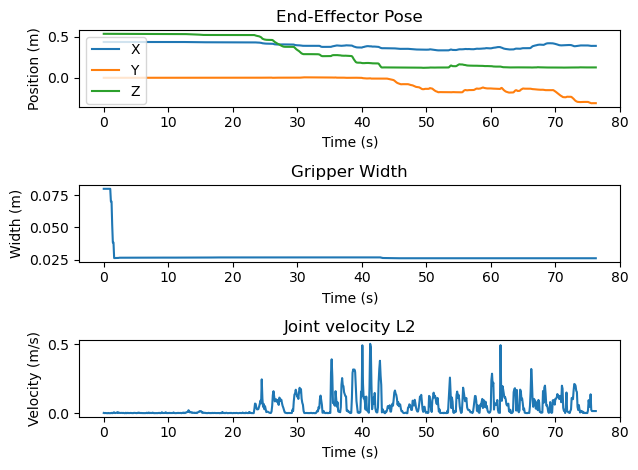

In [168]:
dataloading.plot_demonstration(collate_observations(all_data[2]))

1
(612, 8) 613
1700144814.1630065 1700144873.8856573
1700144831.9031909 1700144893.8487427
1 1722
(1280, 720)


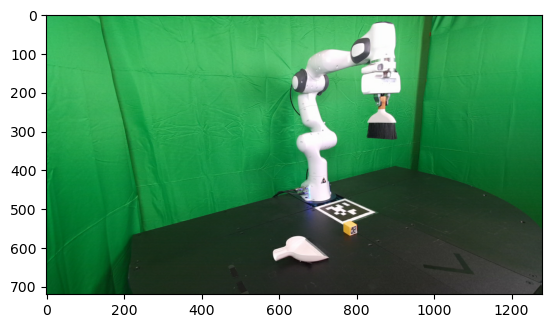

In [177]:
data_id = 15
target_timestamp = 0

participant_id, task_id, interface_id, trial_id = successful_rows[data_id]
obs = dataloading.get_observations(base_dir, participant_id, task_id, interface_id, trial_id)

datum = all_data[data_id]
control_index = np.where((np.array(datum['timestamps']) - datum['timestamps'][0]) > target_timestamp)[0][0]

print(control_index)
print(np.stack(datum['actions']).shape, len(datum['observations']))

print(obs['data']['kinect1']['timestamps'][0], obs['data']['kinect1']['timestamps'][-1])
print(datum['timestamps'][0], datum['timestamps'][-1])

ts = np.array(obs['data']['kinect1']['timestamps'])
ts = ts - obs['data']['kinect1']['timestamps'][0] # datum['timestamps'][0]
for kinect_index in range(len(ts)):
    if ts[kinect_index] > target_timestamp:
        break
        
print(kinect_index, len(ts) - 1)

image_path = os.path.join(obs['root'], "kinect1_color", obs['data']['kinect1']['color_image_paths'][kinect_index])
image = PIL.Image.open(image_path)
print(image.size)
plt.imshow(np.array(image))
plt.show()

In [3]:
from apriltag import apriltag

# try creating extrinsic matrix
import numpy as np

imagepath = 'test.jpg'
image = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
detector = apriltag("tag36h11")
detections = detector.detect(image)
detections

ImportError: cannot import name 'apriltag' from 'apriltag' (unknown location)

In [145]:
# Try generating a video instead

import cv2
import tqdm

fps = 20

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('output.avi', fourcc, fps, (1280, 720))  # Change resolution if needed

data_id = 15
robot_states = all_data[data_id]
participant_id, task_id, interface_id, trial_id = successful_rows[data_id]
obs = dataloading.get_observations(base_dir, participant_id, task_id, interface_id, trial_id)

prev_written_timestamp = -1

# Plot the predicted end-effector position as well

observation_index = 0

for ts, path in tqdm.tqdm(zip(obs['data']['kinect1']['timestamps'], obs['data']['kinect1']['color_image_paths']), desc='Generating video...', total=len(obs['data']['kinect1']['timestamps'])):
    if ts - prev_written_timestamp >= 1/fps:
        prev_written_timestamp = ts
        image_path = os.path.join(obs['root'], "kinect1_color", path)
        image = PIL.Image.open(image_path)
        image_np = np.array(image)
        
        # get closest observation: o(n)
        while observation_index < len(robot_states['timestamp']) and robot_states['timestamp'][observation_index] < ts:
            observation_index += 1
            
        if observation_index < len(robot_states['timestamp']):
            ee_pos = robot_states['ee_pos'][observation_index]
        
        output_video.write(image_np)

output_video.release()

Generating video...: 100%|██████████| 2556/2556 [00:59<00:00, 43.03it/s]


In [ ]:
#### df.to_csv("demonstrations_index.csv")

In [135]:
import numpy as np
import json

demo_index = 0

mask = []

while demo_index < len(df):
    try:
        participant_id, task_id, inferface_id, trial_id = df.iloc[demo_index]

        data = get_teleoperation_index(base_dir, participant_id, task_id, interface_id, trial_id)
        
        t = [d['unix_time_stamp'] for d in data]
        x = [d['eef_pos']['x'] for d in data]
        y = [d['eef_pos']['y'] for d in data]
        z = [d['eef_pos']['z'] for d in data]
        t = np.array(t) - t[0]
        
        # t = data['unix_time_stamp'].to_numpy()
        # t = t - t[0]
        # eef = [json.loads(s.replace("'", "\"").lower()) for s in data['eef_pos'].tolist()]
        # x = [d['x'] for d in eef]
        # y = [d['y'] for d in eef]
        # z = [d['z'] for d in eef]

        if max(x) - min(x) == 0:
            # assume blank run
            raise ValueError("empty dataset")

        plt.title("Teleoperation data")
        plt.plot(t, x, label='X')
        plt.plot(t, y, label='Y')
        plt.plot(t, z, label='Z')
        plt.show()
        
        mask.append(True)
    except Exception as e:
        print(e)
        mask.append(False)
    
    demo_index += 1

empty dataset
empty dataset
[Errno 2] No such file or directory: '/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_1/robot_data_1_3_2_1.pkl'
[Errno 2] No such file or directory: '/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_1/robot_data_1_3_2_1.pkl'
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_2
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_5/Interface_2/Trial_2
empty dataset
empty dataset
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_7/Interface_2/Trial_2
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
Teleoperat

In [ ]:
base_dir = "/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp"
img = PIL.Image.open(base_dir + "/RGB_Data/P_19/Task_3/Interface_1/Trial_1/rs_color/color_frame_293_1700254934.6310108.png")
plt.imshow(img)